# Mercado Inmobiliario

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import utils as Utils
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import mean_squared_error
#plt.style.available

plt.style.use('fivethirtyeight')

## 1. Análisis Exploratorio de Datos

Lectura del dataset:

In [2]:
data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv', parse_dates=[0])

### Primeras 3 filas ###

In [3]:
data.head(3)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta


### Tamaño del dataset: ###

In [4]:
data.shape

(146660, 19)

### Renombrando las columnas l2 y l3

Las columnas "l2" y "l3" se usaran frecuentemente para analisis graficos, por lo tanto es mejor recordar su significado.

In [5]:
cols_rename = {'l2': 'region', 'l3': 'neighborhood'}
data.rename(columns=cols_rename, inplace=True)

### Eliminando columnas irrelevantes

Las columa "created_on" no se utilizara en ningun analisis, asi mismo las columnas "operation_type", "currency" y "l1" poseen el mismo valor en todos los registros, se puede verificar a continuacion:

In [6]:
INDISTINCT_COLUMNS = ['operation_type', 'currency', 'l1']

In [7]:
for col in INDISTINCT_COLUMNS:
    print(col, data[col].value_counts().size)

operation_type 1
currency 1
l1 1


In [8]:
data.drop(columns=INDISTINCT_COLUMNS+['created_on'], inplace=True)
data.shape

(146660, 15)

### Registros duplicados

Se encontraron algunos registros duplicados en el dataframe original:

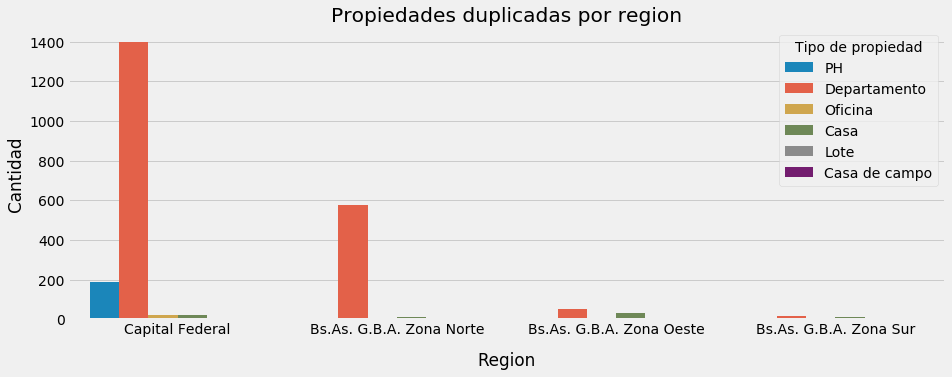

In [9]:
plt.figure(figsize=(14, 5))
plt.title('Propiedades duplicadas por region')
sns.countplot(data=data[data.duplicated()], x='region', hue='property_type')
plt.ylabel('Cantidad')
plt.xlabel('Region', labelpad=15)
legend = plt.legend(loc='upper right')
legend.set_title('Tipo de propiedad')

En todas las regiones predominan los departamentos con caracteristicas, algunos de estos podrian estar ubicados en el mismo edificio, eso explicaria el porque todos los atributos sean iguales incluyendo su latitud y longitud; caso similar ocurre con las oficinas.

### Valores faltantes: ###

Total de valores faltantes por cada columna:

In [10]:
data.isna().sum()

start_date             0
end_date               0
lat                 9925
lon                 9959
region                 0
neighborhood           0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
title                  0
description            0
property_type          0
dtype: int64

### Tipos de propiedad: ###

Tipos de propiedad y cantidad de instancias por cada una

In [11]:
propertyTypes = data['property_type'].value_counts()
pd.DataFrame(propertyTypes)

,property_type
Departamento,107326
Casa,21521
PH,14298
Lote,1312
Oficina,658
Otro,374
Local comercial,325
Casa de campo,322
Depósito,265
Cochera,259


Explorando tipos de propiedad:

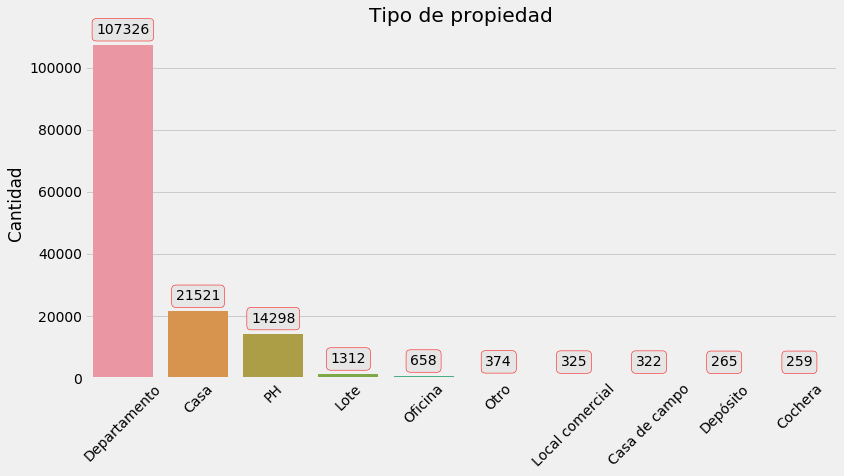

In [12]:
plt.figure(figsize=(12, 6))
Utils.generate_barplot(data, 'property_type', 'Tipo de propiedad', True)

Explorando regiones y barrios:

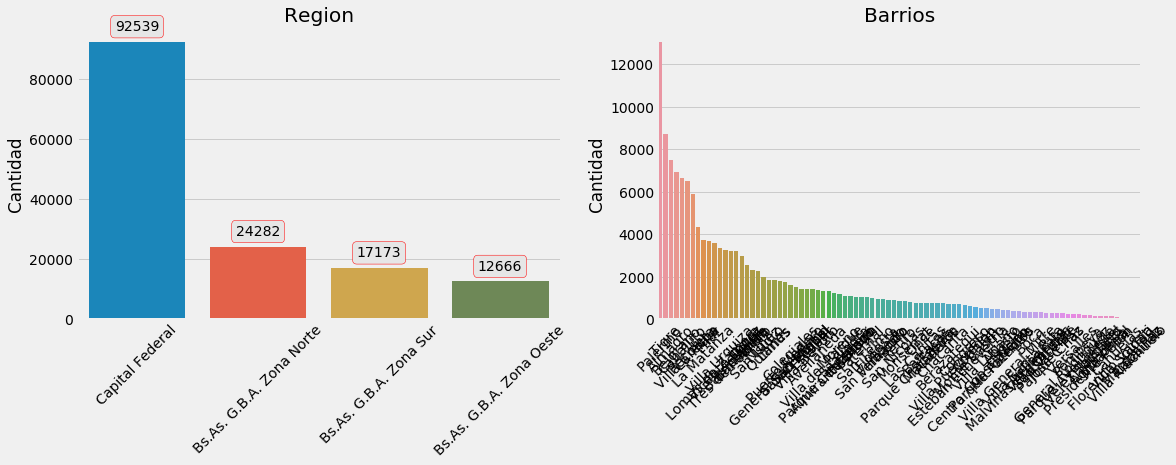

In [13]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
Utils.generate_barplot(data, 'region', 'Region', True)
plt.subplot(1, 2, 2)
Utils.generate_barplot(data, 'neighborhood', 'Barrios')
plt.show()

#### Opcional: Segmentacion del diagrama de barras para la columna barrios. ####

Se ha creado la function **split_barplot()** para graficar diagramas de barras para columnas con numerosas categorias para poder distinguirlas en el eje X.

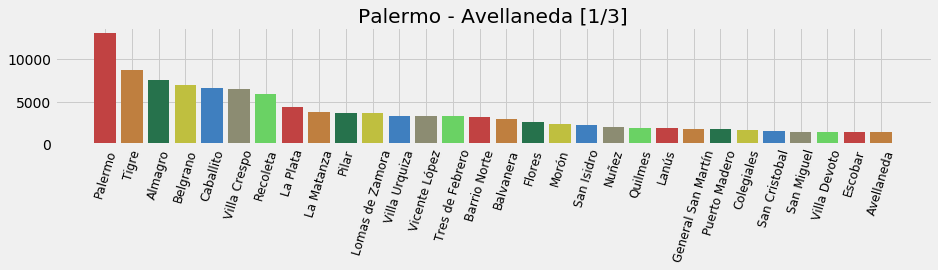

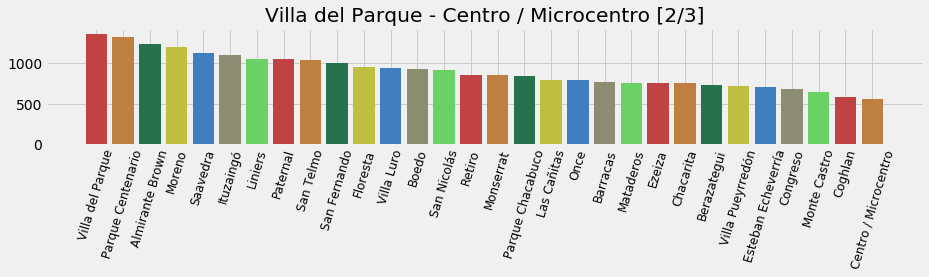

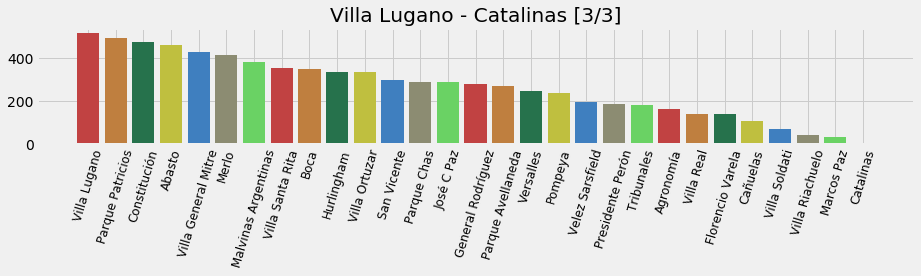

In [14]:
Utils.split_barplot('neighborhood', data, 3)

In [15]:
maxPropertyTypes = propertyTypes.keys()[:3]
print('-> Propiedas con mas publicaciones: {}\n'.format(maxPropertyTypes))

maxRegion = data['region'].value_counts().keys()[0]
print('-> Region con mas publicaciones: {}\n'.format(maxRegion))

-> Propiedas con mas publicaciones: Index(['Departamento', 'Casa', 'PH'], dtype='object')

-> Region con mas publicaciones: Capital Federal



### Busqueda geografica

Se calcularan los establecimientos mas cercanos a un punto dado, para ello se utilizara la distanciia de Haversine o Formula del semiverseno [https://en.wikipedia.org/wiki/Haversine_formula] :


\begin{align}
d = 2r\arcsin\left( \sqrt{\sin^{2} \left( \frac{\phi_2-\phi_1}{2} \right) + cos(\phi_1)cos(\phi_2)\sin^{2} \left( \frac{\lambda_2-\lambda_1}{2} \right)} \right)
\end{align}

Ejemplo de coordenadas (-34.6037389,-58.3837591) pertenecientes al Obelisco de Buenos Aires, obtenidas de https://www.google.com.ar/maps/place/Obelisco/@-34.6037389,-58.3837591,17z

Utilizando estas coordenadas encontramos los **2 departamentos** mas cercanos con una distancia de **16 metros** aproximadamente.

In [16]:
lat, lon = -34.6037389, -58.3837591
Utils.get_nearest_apartments(data, lat, lon)

,start_date,end_date,lat,lon,region,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,title,description,property_type,distance (km)
81864,2019-08-13,9999-12-31,-34.603863,-58.383659,Capital Federal,Abasto,4.0,3.0,2.0,200.0,125.0,220000.0,Venta Departamento en Abasto Capital Federal A...,"Departamento en Venta, Piso sobre av. corrient...",Departamento,0.016824
131833,2019-10-08,9999-12-31,-34.603863,-58.383659,Capital Federal,San Nicolás,4.0,3.0,2.0,200.0,125.0,220000.0,Venta Departamento en San Nicolás Capital Fede...,"Departamento en Venta, Piso sobre av. corrient...",Departamento,0.016824
19301,2020-01-13,2020-01-16,-34.603722,-58.383385,Capital Federal,Tribunales,1.0,1.0,1.0,24.0,NaN,52000.0,Venta Departamento en Tribunales Capital Feder...,"Departamento en Venta, Venta departamento 1 am...",Departamento,0.034829


---
__<font color='red'>NOTA: Ejecutar esta celda para restablecer los valores del dataframe "data_filtered"</font>__

Se ejecutara el primer filtro en un nuevo dataframe que se utilizara en las proximas celdas:

In [17]:
dataFiltered = data[data['property_type'].isin(
    maxPropertyTypes) & (data['region'] == maxRegion)]
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (91485, 15)


### 2. Distribuciones y relaciones de a pares:

#### Se crea una lista para contener las variables:

In [18]:
variables = ['rooms', 'bedrooms', 'bathrooms', 'surface_total',
             'surface_covered', 'price', 'property_type']

#### Obteniendo medidas descriptivas y de dispersión:

In [19]:
dataFiltered[variables].describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,91485.000000,91485.000000,89314.000000,82568.000000,82250.000000,9.148500e+04
mean,2.964278,1.960278,1.560147,112.626369,94.966310,2.595003e+05
std,1.314704,1.072946,0.860309,980.713664,778.515243,3.222654e+05
min,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.200000e+05
50%,3.000000,2.000000,1.000000,71.000000,63.000000,1.750000e+05
75%,4.000000,3.000000,2.000000,111.000000,96.000000,2.790000e+05
max,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


Como se puede ver, existe 1 propiedad que se caracteriza por presentar valores muy atipicos que influyen sobre todos los datos. Por ejemplo, el 75% de estas propiedades tienen 2 baños y existe unicamente una con 14 baños; en la superficie total existe una propiedad con 126062 m2 y el 75% corresponde a una superficie de 111 m2 por lo que la media y desviacion estandar con un valor muy alto indica una clara inconsistencia de datos, este caso es similar a la superficie cubierta.

Si se desease excluir esta propiedad con superficie total maxima, tendriamos que:

In [20]:
pd.DataFrame(dataFiltered.query('surface_total < 126062')['surface_total'].describe())

,surface_total
count,82565.000000
mean,108.049997
std,620.818152
min,10.000000
25%,49.000000
50%,71.000000
75%,111.000000
max,108960.000000


Ahora la media y desviacion estandar disminuyeron, se ha logrado reducir la distancia entre las medidas de superficie haciendo que esta sea mas consistente.

#### Ajustando rango de valores para la variable 'surface_total' del dataframe

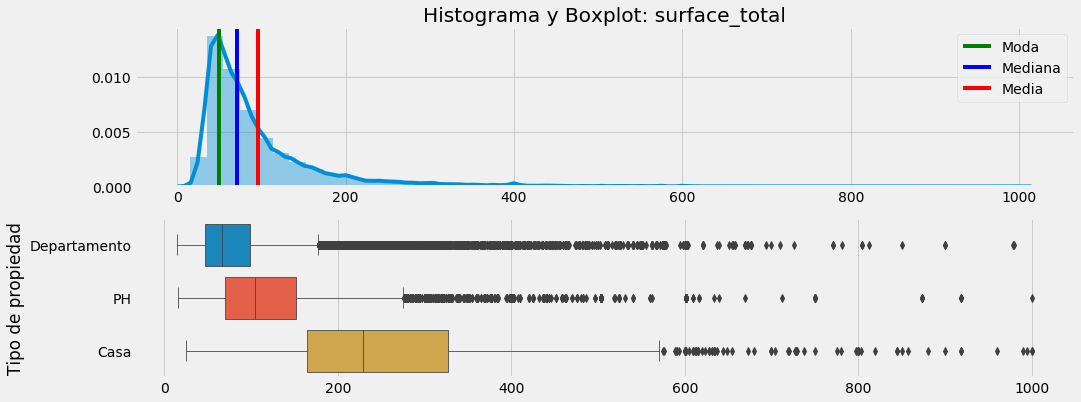

In [21]:
MIN_SURF, MAX_SURF = 15, 1000
Utils.plot_distribution(column_name='surface_total',
                        min_pivot=MIN_SURF, max_pivot=MAX_SURF, dataframe=dataFiltered)

* Se genero un boxplot de superficie total por cada tipo de propiedad para observar la cantidad de outlier en cada una de estas clases.

* Esta variable presenta asimetria y mas particularmente, una **asimetria positiva** porque su Media > Mediana > Moda.

* Se ajusto un rango de superficies total de entre **15** y **1000** m2

In [22]:
dataFiltered = dataFiltered.query(f'{MIN_SURF} <= surface_total <=  {MAX_SURF}')
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (82405, 15)


#### Ajustando rango de valores para la variable 'price' del dataframe

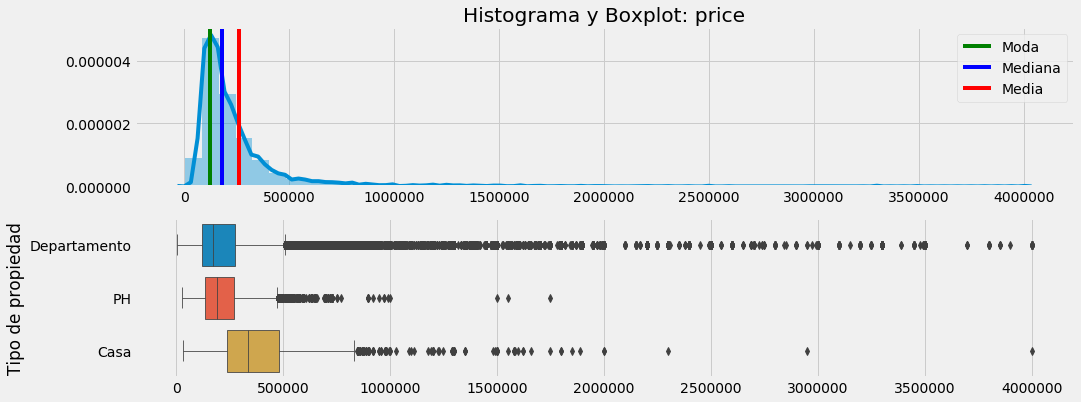

In [24]:
MIN_PRICE, MAX_PRICE = 0, 4000000
Utils.plot_distribution(column_name='price', max_pivot=MAX_PRICE, dataframe=dataFiltered)

* Se genero un boxplot del precio por cada Tipo de propiedad para observar la cantidad de outlier en cada una de estas clases.

* Esta variable tambien presenta **asimetria positiva**.

* Se ajusto un rango de precios total de entre **0** y **4000000**.

In [25]:
dataFiltered = dataFiltered.query(f'{MIN_PRICE} <= price <=  {MAX_PRICE}')
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (82373, 15)


#### Eliminando instancias faltantes

Seleccionamos los siguientes atributos del dataframe antes de eliminar los valores faltantes:

In [26]:
dataFiltered=dataFiltered[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price','region', 'neighborhood', 'start_date','property_type' ]]
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (82373, 10)


Explorando valores faltandes con las columnas que se han elegido:

In [27]:
dataFiltered.isna().sum()

rooms                0
bedrooms             0
bathrooms          880
surface_total        0
surface_covered    517
price                0
region               0
neighborhood         0
start_date           0
property_type        0
dtype: int64

Las unicas columnas que presentan valores faltantes son **"bathrooms"** y **"surface_covered"**. En el siguiente paso se obtendra un dataframe sin estos valores:

In [28]:
dataFiltered.dropna(inplace=True)
print('-> Nuevas dimensiones: ', dataFiltered.shape)

-> Nuevas dimensiones:  (81019, 10)


#### Evolución Precio vs Periodo

A continuación se genera un diagrama para observar la relación del precio conforme avanza el tiempo, el eje X corresponde a periodos mensuales desde Enero de 2019 hasta Enero de 2020 y en el eje Y, el promedio del precio en tal período.

Asi se calcula el período utilizando la columna **"start_date"** del dataframe filtrado.

In [29]:
dataFiltered['period']=dataFiltered['start_date'].dt.to_period('M').astype('str')

Se creó la siguiente función para generar un lineplot de Seaborn, su único parámetro corresponde al dataframe:

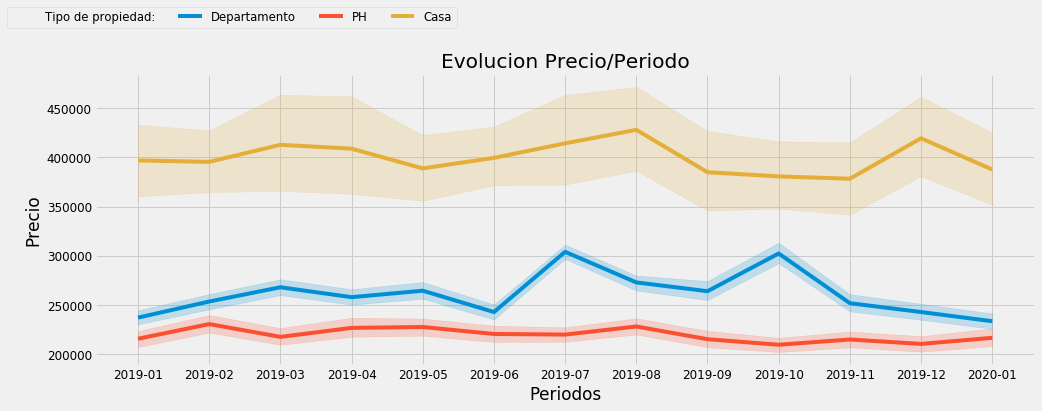

In [30]:
Utils.plot_price_by_period(dataFiltered)

* La escala de precios para las casas supera enormemente a la de departamentos y PH, y presenta pocas variaciones.
* El precio de las propiedades PH y departamentos son similares, excepto en el periodo de Julio a Noviembre de 2019 en donde se aumento el valor de los PH.

Se eliminan las columnas del dataframe para continuar con los próximos análisis:

In [32]:
print('Antes: ', dataFiltered.columns)
colsDrop = set(dataFiltered.columns)-set(variables)
if set(colsDrop).issubset(dataFiltered.columns):
    dataFiltered.drop(columns=colsDrop, inplace=True)
print('Despues: ', dataFiltered.columns)

Antes:  Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'property_type'],
      dtype='object')
Despues:  Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'property_type'],
      dtype='object')


#### Correlaciones:

Generando graficos de dispersion e histograma para cada par de variable utiliando:

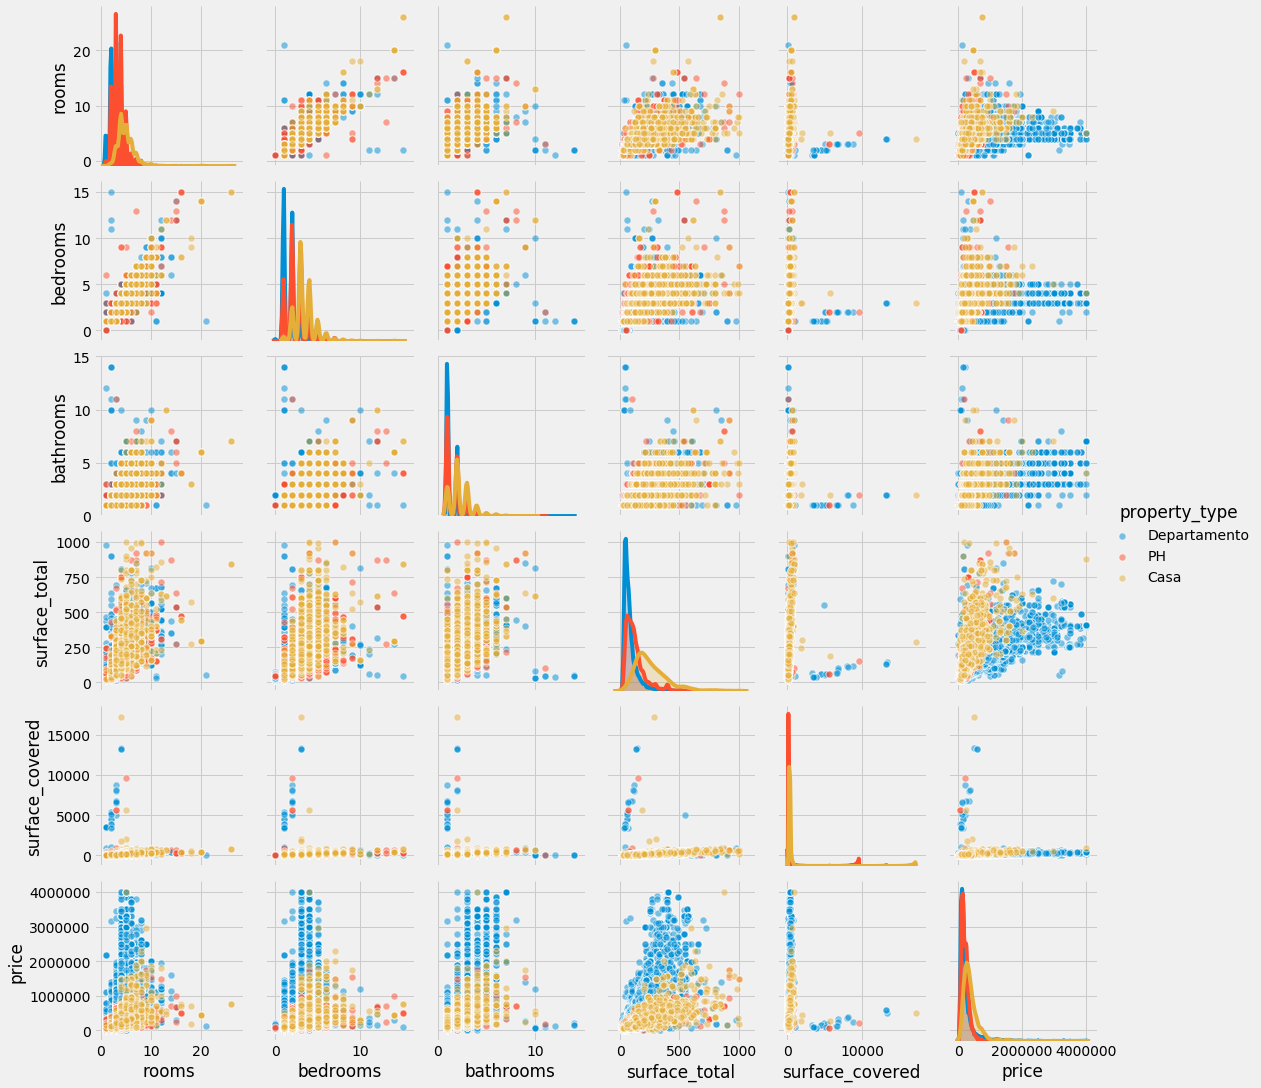

In [33]:
sns.pairplot(dataFiltered, hue='property_type', plot_kws=dict(s=50, linewidth=1, alpha=.5))

Generando mapa de correlaciones **Pearson** y **Spearman** en (Formato Heatmap) para cada par de variable del dataframe:

La función **plot_heatmaps()** fué creada para ese propósito:

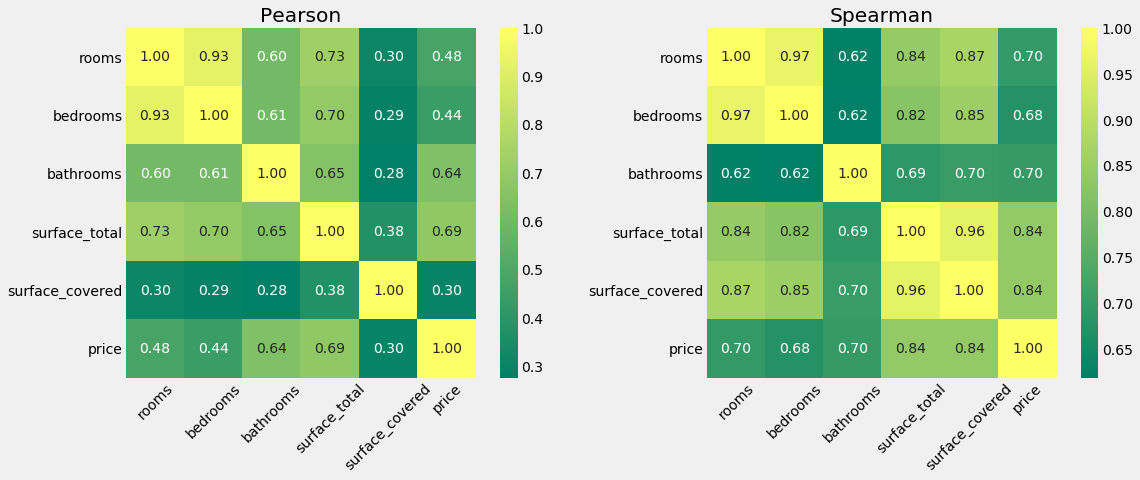

In [34]:
Utils.plot_heatmaps(dataFiltered)

**Pearson:** Existe alta correlacion entre la variable "*price*" con la **superficie total** con un valor de 0.69 y el **numero de baños** con un valor de 0.64, por lo tanto, podrian ser las variables regresoras con mayor influencia a la hora de de entrenar el modelo, y "*surface_covered*" con menor influencia.

**Spearman:** Existe alta correlacion entre la variable "*price*" con la **superficie total** y **cubierta** con un valor de 0.84 para ambas, por lo tanto, podrian ser las variables regresoras con mayor influencia a la hora de de entrenar el modelo, y "*bedrooms*" con menor influencia.

## 3. Machine Learning

Creamoslos datos de entrenamiento y validacion:

In [36]:
X=dataFiltered[variables[:5]]
y=dataFiltered[['price']]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

In [56]:
dataFiltered.shape, X_train.shape, X_test.shape

((67619, 7), (47333, 5), (20286, 5))

### Modelo inicial

In [35]:
initialModelTree, initialModelKnn = DecisionTreeRegressor(max_depth=3, random_state=42), KNeighborsRegressor(n_neighbors=5)

In [80]:
initialModelTree.fit(X_train, y_train)
initialModelKnn.fit(X_train, y_train)
print(initialModelKnn.score(X_test, y_test))

0.673170217194341


Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 51512.55074574962
Raíz del error cuadrático medio en Test: 51181.50132013465


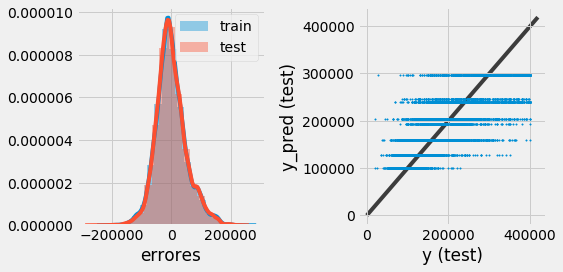

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 39164.19276472928
Raíz del error cuadrático medio en Test: 44603.3727297617


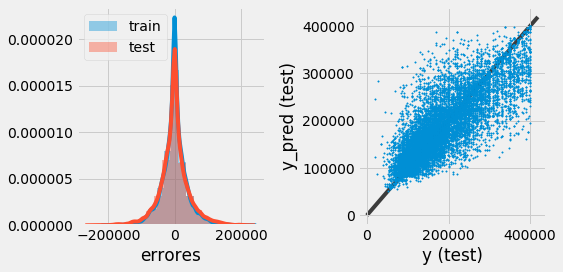

In [71]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([initialModelTree, initialModelKnn]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test=np.array(y_test).reshape(-1,1)
    y_train= np.array(y_train).reshape(-1,1)
    y_train_pred=np.array(y_train_pred).reshape(-1,1)
    y_test_pred=np.array(y_test_pred).reshape(-1,1)
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

### Curva de validacion

In [57]:
degree = np.arange(1, 21, 1)

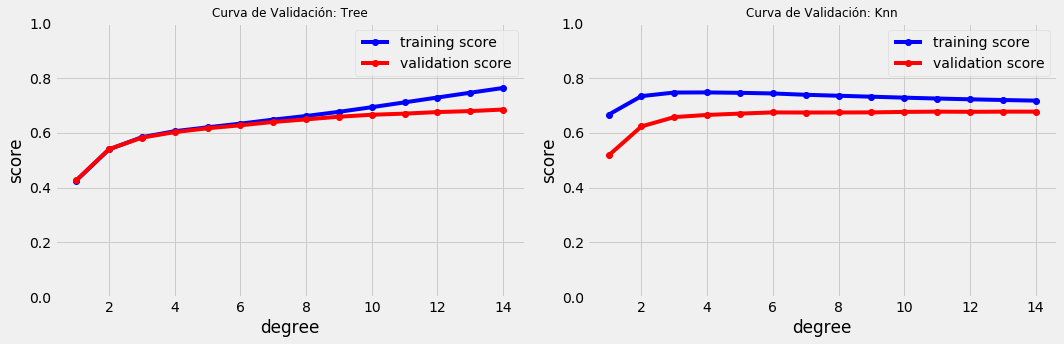

In [58]:
arange =  np.arange(1,15,1)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
Utils.plot_validation_curve('tree', X, y, arange)
plt.subplot(1,2,2)
Utils.plot_validation_curve('knn', X, y, arange)
plt.tight_layout()

### Curva de Errores

In [72]:
def plot_rmse_curve(model_type, X_train, X_test, y_train, y_test, k_values):
    list_rmse_train = np.zeros(len(k_values))
    list_rmse_test = np.zeros(len(k_values))
    for index, k in enumerate(k_values):
        model = DecisionTreeRegressor(max_depth=k, random_state=42)
        if (model_type=='knn'):
            model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
        y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        list_rmse_train[index]=rmse_train
        list_rmse_test[index]=rmse_test
    title='Curva de Errores: '
    title+='Tree' if model_type=='tree' else 'Knn'
    plt.title(title, fontdict=dict(fontsize= 12))
    plt.plot(k_values, list_rmse_train, 'bo-')
    plt.plot(k_values, list_rmse_test, 'ro-')
    plt.xlabel('Complejidad')
    plt.ylabel('RMSE')
    plt.legend(['Train', 'Test'])

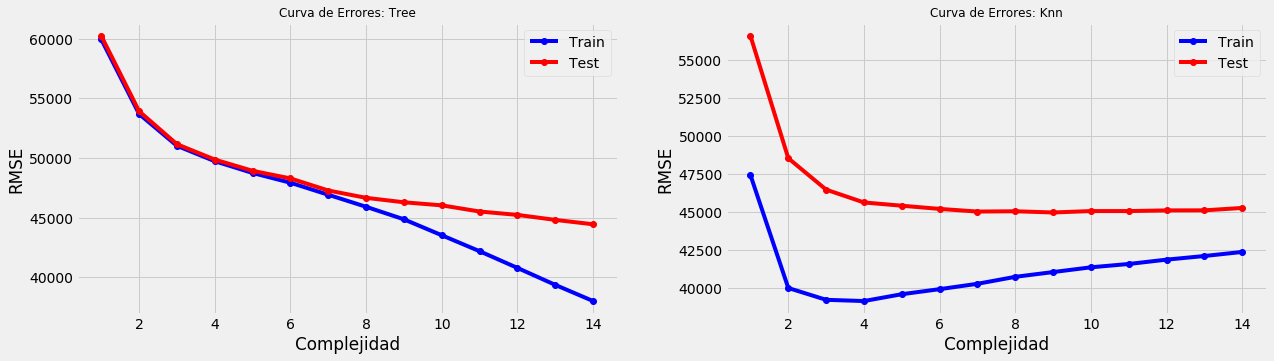

In [73]:
plt.figure(figsize = (19,5))
plt.subplot(1,2,1)
plot_rmse_curve('tree',
                      X_train = X_train, 
                      X_test  = X_test, 
                      y_train = y_train, 
                      y_test  = y_test, 
                      k_values= arange)
plt.subplot(1,2,2)
plot_rmse_curve('knn', 
                      X_train = X_train, 
                      X_test  = X_test, 
                      y_train = y_train, 
                      y_test  = y_test, 
                      k_values= arange)